# Notebook Tạo Hình ảnh Báo cáo (Chương 6)

**Mục tiêu:** Chạy lại pipeline huấn luyện cho cả 4 mô hình (LR, KNN, DT, RF), tìm ra mô hình tốt nhất (tuned) của mỗi loại, và lưu lại các hình ảnh (plots) cần thiết cho báo cáo LaTeX.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Thiết lập style chung
sns.set_theme(style="whitegrid")
print("Tất cả thư viện đã được import.")

Tất cả thư viện đã được import.


## Giai đoạn 1: Tải và Tiền xử lý Dữ liệu (Chung)

Thực hiện các bước tiền xử lý như đã thống nhất: load, xóa trùng lặp, one-hot encoding, và chia train/test. Chúng ta sẽ tạo ra 2 bộ train/test:
1.  `..._scaled`: Dữ liệu đã chuẩn hóa (cho LR và KNN).
2.  `..._unscaled`: Dữ liệu gốc đã encoding (cho DT và RF).

In [2]:
# Tải dữ liệu
data = pd.read_csv('heart.csv')

# Xóa các hàng trùng lặp
data = data.drop_duplicates()

# Tách X(features) và y(target)
X = data.drop('HeartDisease', axis=1)
Y = data["HeartDisease"]

# 1. Biến Categorical: One-hot Encoding
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Lấy tên đặc trưng để vẽ cây
feature_names = X_encoded.columns.tolist()

# 2. Chia dữ liệu (CẢ HAI BỘ)
X_train_unscaled, X_test_unscaled, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

# 3. Tạo bộ dữ liệu Scaled (cho LR, KNN)
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()

# Tạo bản copy để tránh thay đổi dữ liệu unscaled
X_train_scaled = X_train_unscaled.copy()
X_test_scaled = X_test_unscaled.copy()

# Chỉ FIT trên train_scaled
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_unscaled[numerical_cols])
# Chỉ TRANSFORM trên test_scaled
X_test_scaled[numerical_cols] = scaler.transform(X_test_unscaled[numerical_cols])

print(f"Đã chuẩn bị xong 2 bộ dữ liệu:")
print(f"- Scaled Train: {X_train_scaled.shape}")
print(f"- Unscaled Train: {X_train_unscaled.shape}")

Đã chuẩn bị xong 2 bộ dữ liệu:
- Scaled Train: (734, 15)
- Unscaled Train: (734, 15)


## Giai đoạn 2: Hồi quy Logistic (LR) & Lưu hình

Bắt đầu huấn luyện Logistic Regression...
Đã lưu 'hinh-cm-lr.png'


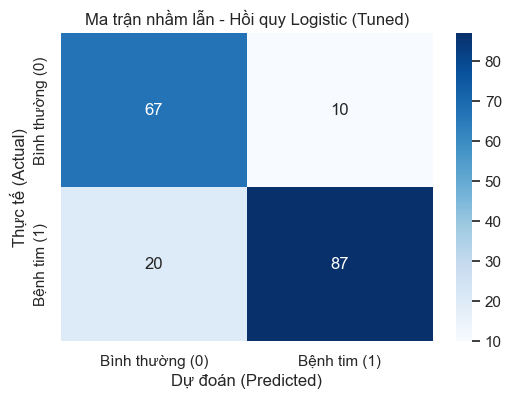

In [3]:
print("Bắt đầu huấn luyện Logistic Regression...")
# Tinh chỉnh (Tuning) LR
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_scaled, Y_train)

# Lấy mô hình tốt nhất
best_lr = grid_lr.best_estimator_
Y_pred_lr = best_lr.predict(X_test_scaled)

# 1. Tạo hình: Ma trận nhầm lẫn (hinh-cm-lr.png)
cm_lr = confusion_matrix(Y_test, Y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bình thường (0)', 'Bệnh tim (1)'], 
            yticklabels=['Bình thường (0)', 'Bệnh tim (1)'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Ma trận nhầm lẫn - Hồi quy Logistic (Tuned)')

# Lưu file
plt.savefig('hinh-cm-lr.png', dpi=300, bbox_inches='tight')
print("Đã lưu 'hinh-cm-lr.png'")
plt.show()

## Giai đoạn 3: K-Nearest Neighbors (KNN) & Lưu hình

Bắt đầu huấn luyện KNN...
Đã lưu 'hinh-knn-elbow.png'


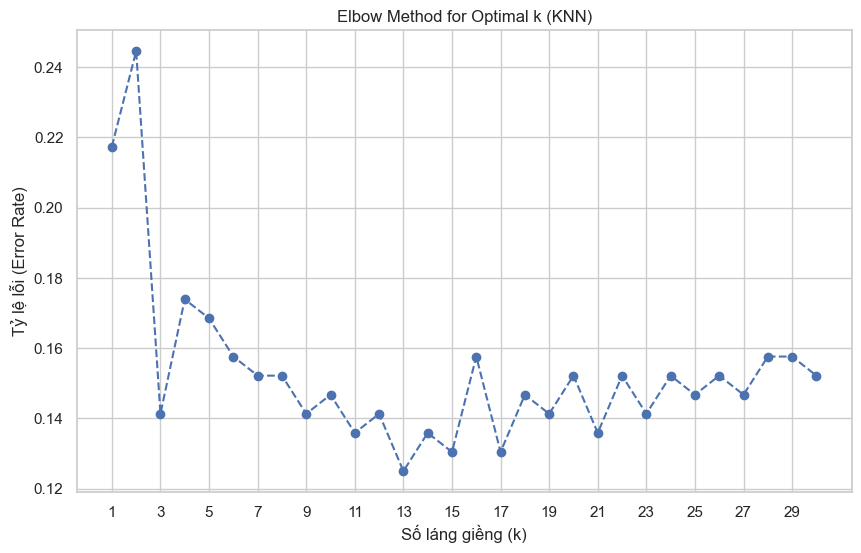

Đã lưu 'hinh-cm-knn.png'


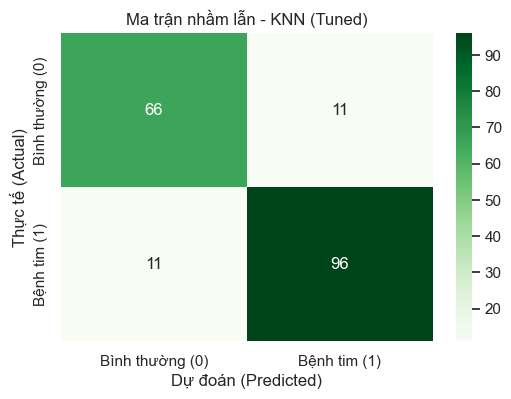

In [4]:
print("Bắt đầu huấn luyện KNN...")

# 2. Tạo hình: Elbow Method (hinh-knn-elbow.png)
error_rates = []
k_values = range(1, 31)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, Y_train)
    Y_pred_k = knn.predict(X_test_scaled)
    # Error Rate = 1 - Accuracy
    error = np.mean(1 - accuracy_score(Y_test, Y_pred_k))
    error_rates.append(error)

# Vẽ biểu đồ Error Rate
plt.figure(figsize=(10, 6))
plt.plot(k_values, error_rates, marker='o', linestyle='dashed')
plt.title('Elbow Method for Optimal k (KNN)')
plt.xlabel('Số láng giềng (k)')
plt.ylabel('Tỷ lệ lỗi (Error Rate)')
plt.xticks(k_values[::2]) # Hiển thị cách 2 số
plt.grid(True)

# Lưu file
plt.savefig('hinh-knn-elbow.png', dpi=300, bbox_inches='tight')
print("Đã lưu 'hinh-knn-elbow.png'")
plt.show()

# Tinh chỉnh (Tuning) KNN
param_grid_knn = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['distance', 'uniform'],
    'metric': ['euclidean', 'manhattan']
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train_scaled, Y_train)

best_knn = grid_knn.best_estimator_
Y_pred_knn = best_knn.predict(X_test_scaled)

# 3. Tạo hình: Ma trận nhầm lẫn (hinh-cm-knn.png)
cm_knn = confusion_matrix(Y_test, Y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Bình thường (0)', 'Bệnh tim (1)'], 
            yticklabels=['Bình thường (0)', 'Bệnh tim (1)'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Ma trận nhầm lẫn - KNN (Tuned)')

# Lưu file
plt.savefig('hinh-cm-knn.png', dpi=300, bbox_inches='tight')
print("Đã lưu 'hinh-cm-knn.png'")
plt.show()

## Giai đoạn 4: Decision Tree (DT) & Lưu hình

Sử dụng bộ `_unscaled` cho mô hình này.

Bắt đầu huấn luyện Decision Tree...


C:\Users\LEGION\AppData\Local\Temp\ipykernel_520\653962974.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


Đã lưu 'hinh-dt-importance.png'


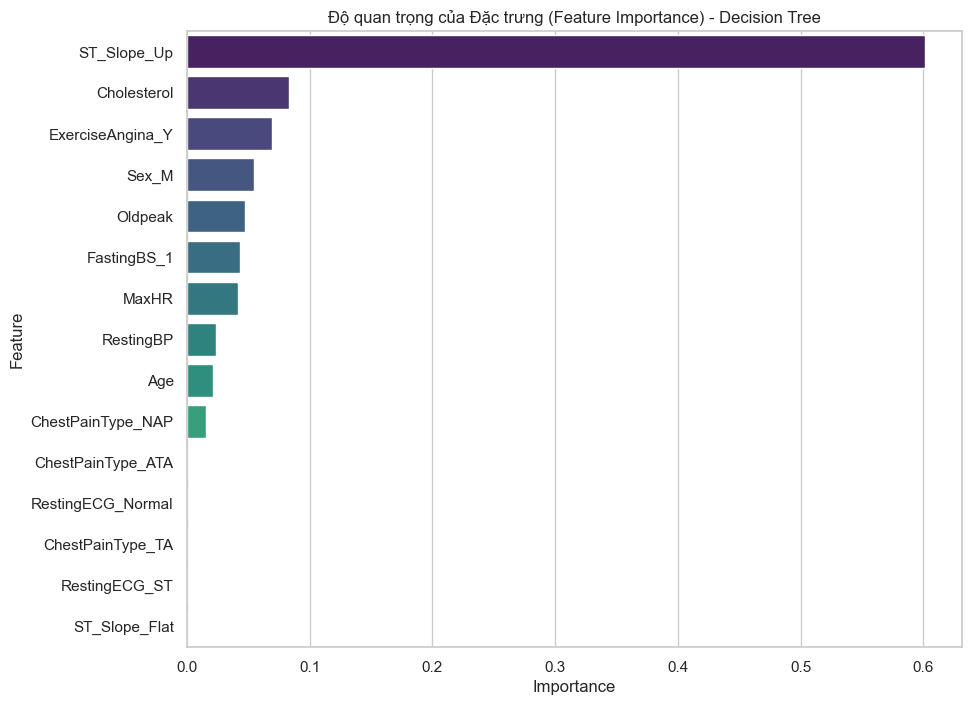

Đã lưu 'hinh-dt-tree.png'


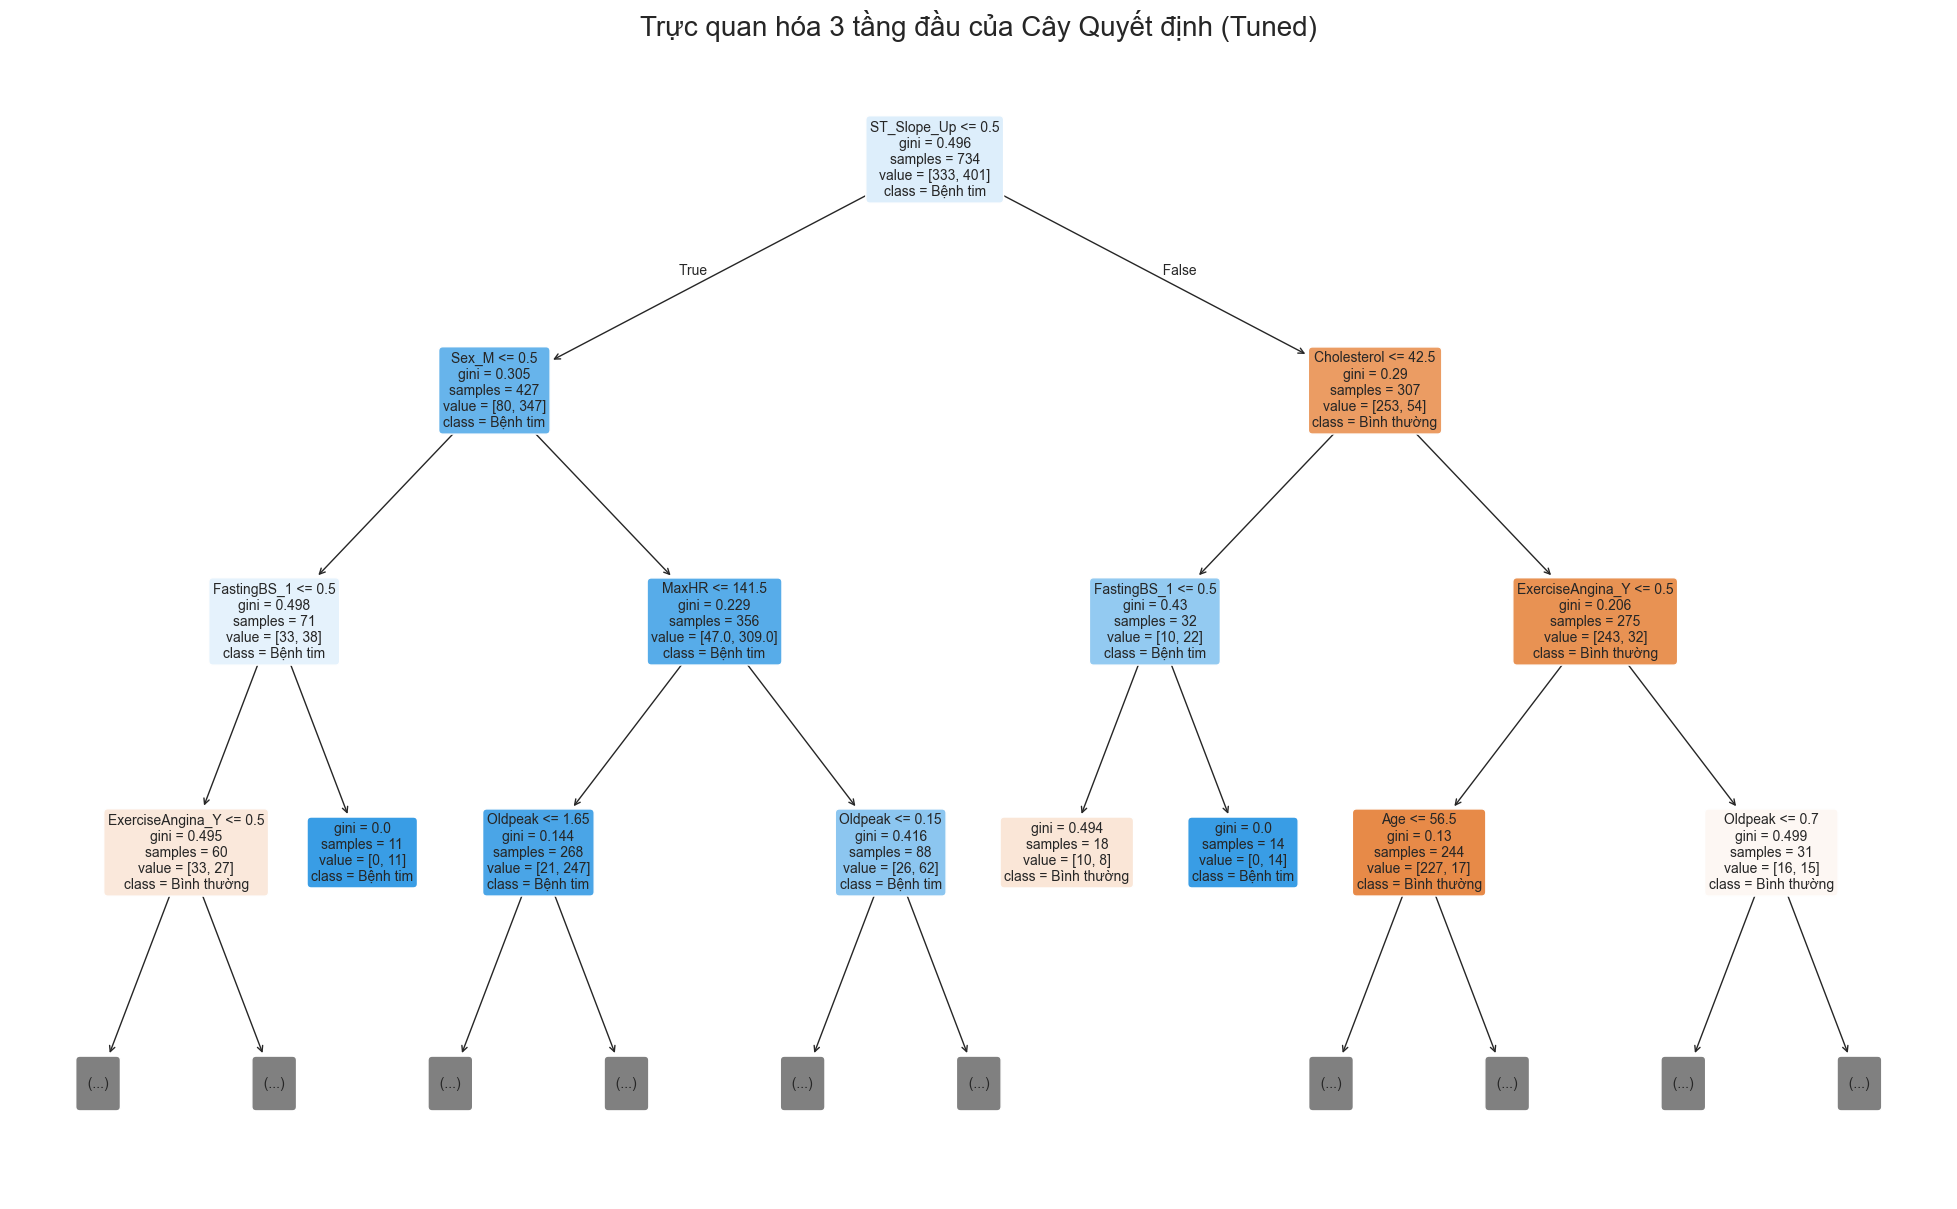

In [5]:
print("Bắt đầu huấn luyện Decision Tree...")
# Tinh chỉnh (Tuning) DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train_unscaled, Y_train)

best_dt = grid_dt.best_estimator_

# 4. Tạo hình: Feature Importance (hinh-dt-importance.png)
importances_dt = best_dt.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_dt
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Độ quan trọng của Đặc trưng (Feature Importance) - Decision Tree')

# Lưu file
plt.savefig('hinh-dt-importance.png', dpi=300, bbox_inches='tight')
print("Đã lưu 'hinh-dt-importance.png'")
plt.show()

# 5. Tạo hình: Cấu trúc Cây (hinh-dt-tree.png)
plt.figure(figsize=(25, 15)) # Kích thước lớn để dễ đọc
class_names = ['Bình thường', 'Bệnh tim']

plot_tree(
    best_dt, 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True, 
    fontsize=10,
    max_depth=3 # Chỉ vẽ 3 tầng đầu cho rõ ràng
)
plt.title("Trực quan hóa 3 tầng đầu của Cây Quyết định (Tuned)", fontsize=20)

# Lưu file
plt.savefig('hinh-dt-tree.png', dpi=300, bbox_inches='tight')
print("Đã lưu 'hinh-dt-tree.png'")
plt.show()

## Giai đoạn 5: Random Forest (RF) & Lưu hình

Sử dụng bộ `_unscaled` cho mô hình này.

Bắt đầu huấn luyện Random Forest (Có thể mất vài phút)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Đã lưu 'hinh-cm-rf.png'


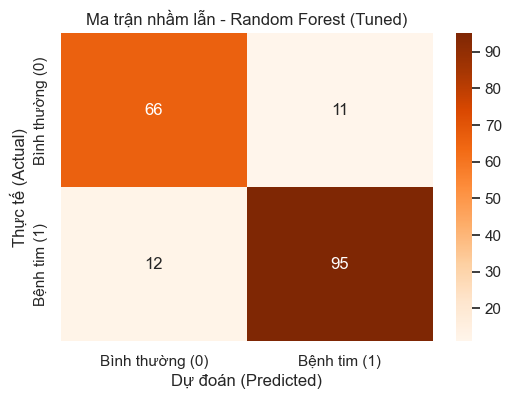

C:\Users\LEGION\AppData\Local\Temp\ipykernel_520\1217283822.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf.head(15), palette='mako')


Đã lưu 'hinh-rf-importance.png'


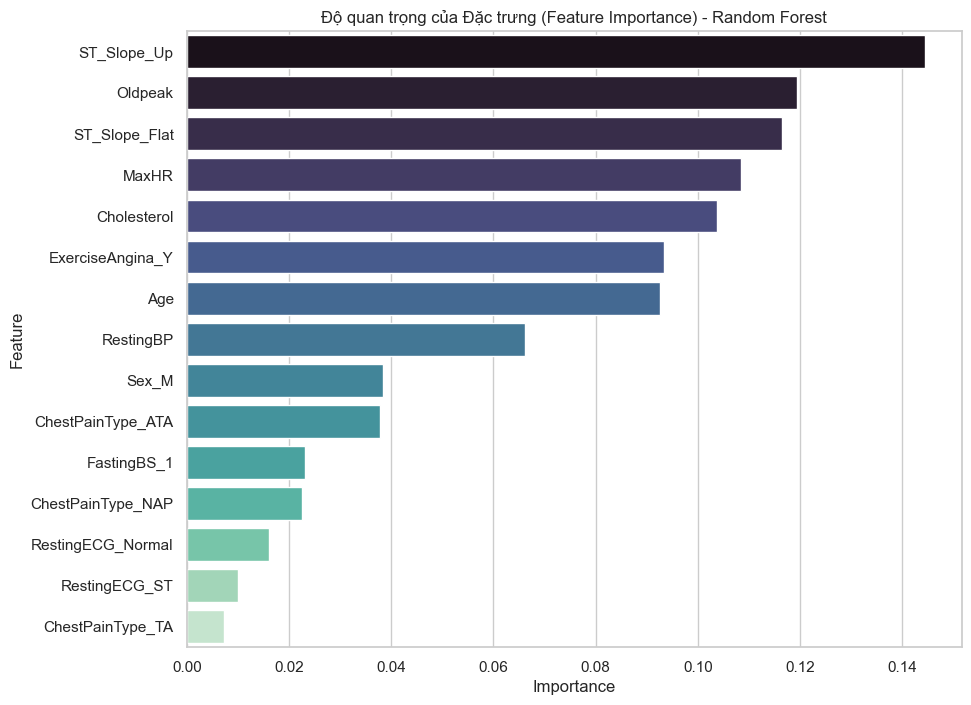

In [6]:
print("Bắt đầu huấn luyện Random Forest (Có thể mất vài phút)...")
# Tinh chỉnh (Tuning) RF
# LƯU Ý: GridSearch này chạy khá lâu.
# Để chạy nhanh, bạn có thể giảm số lượng giá trị trong lưới (ví dụ: 'n_estimators': [100])
param_grid_rf = {
    'n_estimators': [100, 200], # Giảm từ [100, 200, 300]
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                       param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_unscaled, Y_train)

best_rf = grid_rf.best_estimator_
Y_pred_rf = best_rf.predict(X_test_unscaled)

# 6. Tạo hình: Ma trận nhầm lẫn (hinh-cm-rf.png)
cm_rf = confusion_matrix(Y_test, Y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Bình thường (0)', 'Bệnh tim (1)'], 
            yticklabels=['Bình thường (0)', 'Bệnh tim (1)'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Ma trận nhầm lẫn - Random Forest (Tuned)')

# Lưu file
plt.savefig('hinh-cm-rf.png', dpi=300, bbox_inches='tight')
print("Đã lưu 'hinh-cm-rf.png'")
plt.show()

# 7. Tạo hình: Feature Importance (hinh-rf-importance.png)
importances_rf = best_rf.feature_importances_
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf.head(15), palette='mako')
plt.title('Độ quan trọng của Đặc trưng (Feature Importance) - Random Forest')

# Lưu file
plt.savefig('hinh-rf-importance.png', dpi=300, bbox_inches='tight')
print("Đã lưu 'hinh-rf-importance.png'")
plt.show()

## HOÀN THÀNH

Đã tạo và lưu tất cả 7 hình ảnh cho Chương 6.